# Fraud data analysis

## Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Kaggle dataset

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [133]:
try:
    import opendatasets as od
except:
    print("Installing opendatasets")
    !pip install opendatasets
    import opendatasets as od

In [134]:
try:
    df = pd.read_csv("./creditcardfraud/creditcard.csv")

except Exception as e:
    print("Downloading dataset")
    od.download("https://www.kaggle.com/mlg-ulb/creditcardfraud")
    try:
        df = pd.read_csv("./creditcardfraud/creditcard.csv")
    except:
        raise

# EDA

Before starting any project I like doing a good exploratory data analysis. Making sure you properly understand the data may save you a lot of time when coding later on.

## Looking at generic data properties

First thing I like to do is to have a look at the data to become familiar with it. I want to know its size and what the columns are. I also look for any missing values or any inconsistent data types

In [135]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


DATA: 28 unknown PCA variables, time of transaction, amount and class

In [136]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Most of the data is non fraudulent, average transaction is 88

In [137]:
df[["Amount", "Class"]].describe().round(3)

,Amount,Class
count,284807.000,284807.000
mean,88.350,0.002
std,250.120,0.042
min,0.000,0.000
25%,5.600,0.000
50%,22.000,0.000
75%,77.165,0.000
max,25691.160,1.000


No missing values or inconsistent types

In [138]:
a = pd.DataFrame([df.isna().sum(), df.dtypes]).T
a.columns = ["Missing Values", "Type"]
a

,Missing Values,Type
Time,0,float64
V1,0,float64
V2,0,float64
V3,0,float64
V4,0,float64
V5,0,float64
V6,0,float64
V7,0,float64
V8,0,float64
V9,0,float64


## Visualisations

Here I focus on visualisations to do with fraudulent transactions because it is what we are interested in. It is difficult sometimes to do with specially with a dataset this unbalanced

## FRAUD

In [139]:
fraud = df.loc[df["Class"] == 1]
nofraud = df.loc[df["Class"] == 0]

In [140]:
len(fraud), len(df)

(492, 284807)

In [141]:
df.shape

(284807, 31)

In [150]:
def plot_data(fraud, nofraud = None, synth = None, features=None):
    """
    Input: 2 dataframes, fraudulent transactions and non fraudulent
           list of features to visualise 
    
    Output:
    normalised histograms of the selected features
    """
    
    if features == None:
        features = df.columns
    
    try:
        fraud = fraud[features]
         
        if type(nofraud) == pd.DataFrame:
            nofraud = nofraud[features]
        if type(synth) == pd.DataFrame:
            synth = synth[features]
    except:
        raise
        return()
    
    n_rows = len(features)//3 +1

    _, ax = plt.subplots(n_rows, 3, figsize = (5*3, 5*n_rows))
    

    for index, i in enumerate(features):
        axis = ax[index//3][index%3]
        if type(nofraud) == pd.DataFrame:
            axis.hist(nofraud[i], density = True, bins = 50, stacked = True, label = "Non Fraudulent")
        if type(synth) == pd.DataFrame:
            axis.hist(synth[i], density = True, bins = 50, stacked = True, label = "Synth Fraudulent")
            
        axis.hist(fraud[i], bins = 50, density = True, stacked = True, label = "Fraudulent")
        axis.set_title(i)
        axis.set_ylabel("Percentage of transactions")
        axis.set_xlabel("Value of {}".format(i))
        axis.legend()
    plt.tight_layout()

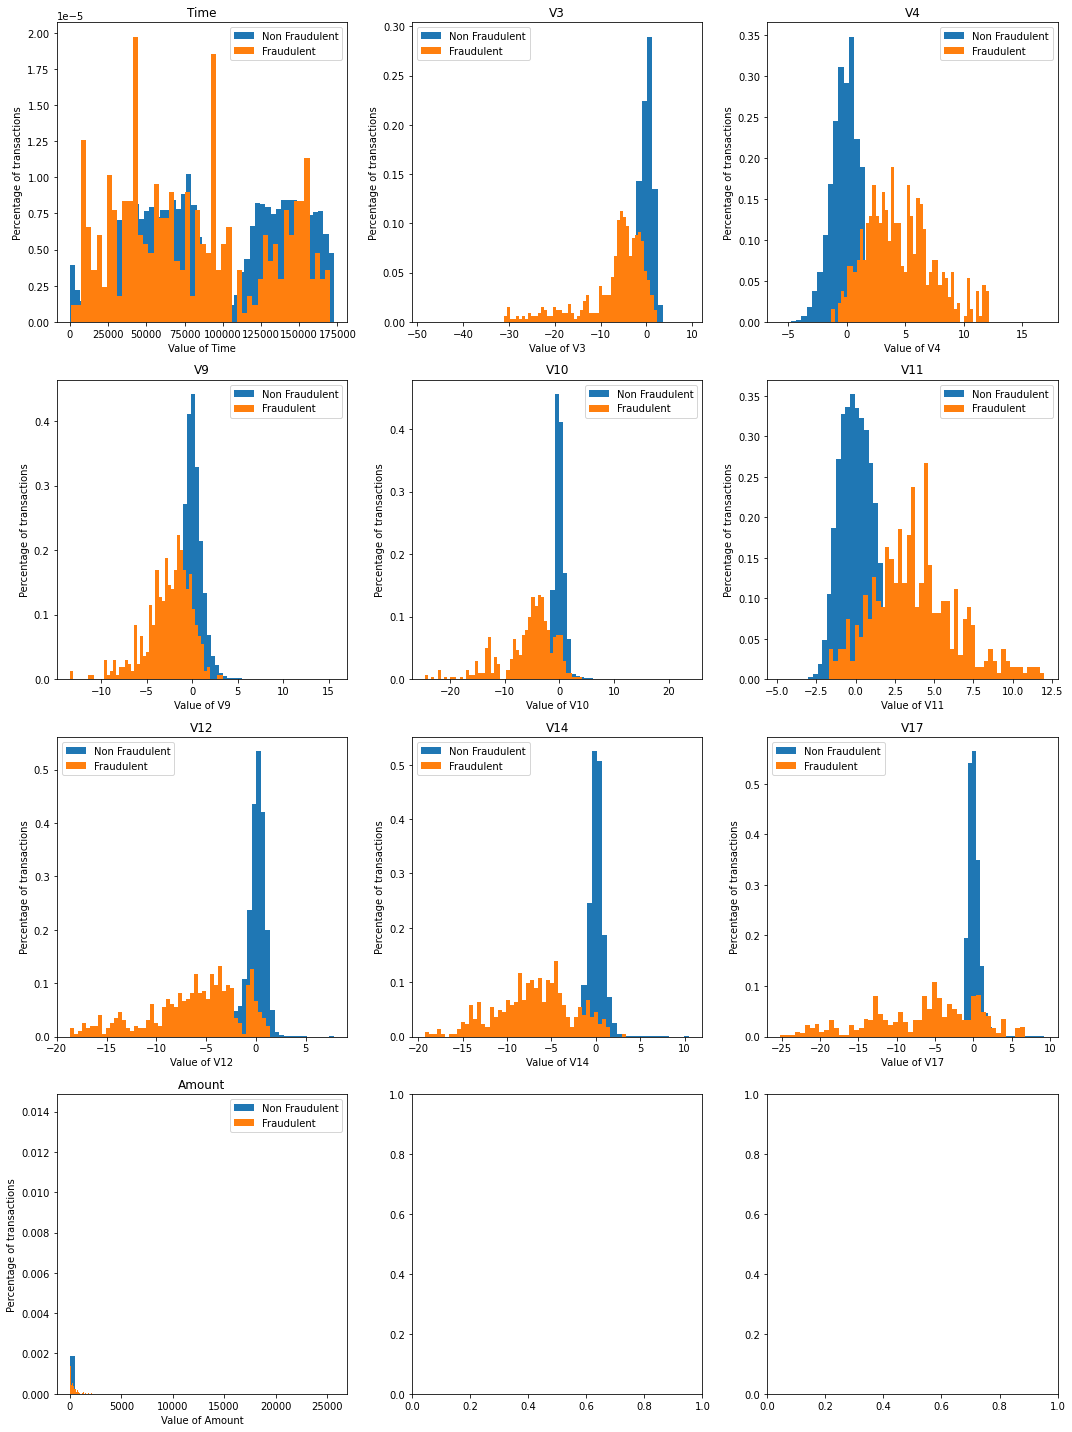

In [151]:
plot_data(fraud, nofraud = nofraud, features = ["Time", "V3", "V4", "V9", "V10", "V11", "V12", "V14", "V17", "Amount"])

In [13]:
guess = df.loc[df["V14"] < -3]

In [14]:
guess.shape

(2388, 31)

In [15]:
guess_fraud = guess.loc[guess["Class"]== 1]

In [16]:
len(guess_fraud)/len(fraud)

0.823170731707317

In [17]:
len(guess_fraud)/len(guess)

0.16959798994974876

## AMOUNT AND FRAUD

I'm curious about the amount transfered and the fraud. Amount is the only variable we know other than time and fraud

<ipython-input-18-4116f14ad675>:2: RuntimeWarning: divide by zero encountered in log
  ax[1].plot(np.log(sorted(df["Amount"])))


Text(0, 0.5, 'Amount')

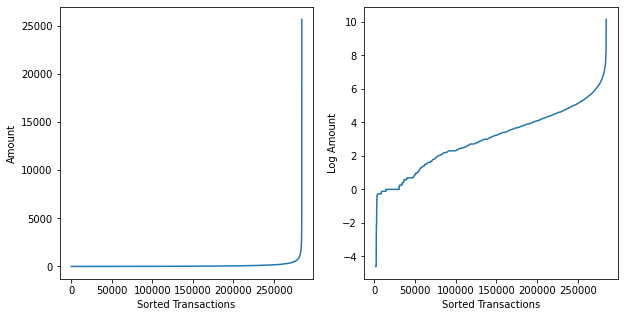

In [18]:
_, ax = plt.subplots(1,2, figsize= (10, 5))
ax[1].plot(np.log(sorted(df["Amount"])))
ax[1].set_xlabel("Sorted Transactions")
ax[1].set_ylabel("Log Amount")

ax[0].plot(sorted(df["Amount"]))
ax[0].set_xlabel("Sorted Transactions")
ax[0].set_ylabel("Amount")

<ipython-input-19-3a7ef4c47dca>:2: RuntimeWarning: divide by zero encountered in log
  ax[1].scatter(np.linspace(0, 1, len(fraud)), np.log(sorted(fraud["Amount"])), s = 1, label = "Fraud")
<ipython-input-19-3a7ef4c47dca>:3: RuntimeWarning: divide by zero encountered in log
  ax[1].scatter(np.linspace(0, 1, len(nofraud)), np.log(sorted(nofraud["Amount"])), s =1, label = "No Fraud")


Text(0, 0.5, 'Amount')

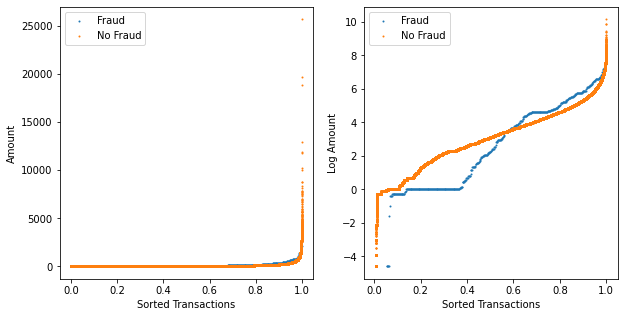

In [19]:
_, ax = plt.subplots(1,2, figsize= (10, 5))
ax[1].scatter(np.linspace(0, 1, len(fraud)), np.log(sorted(fraud["Amount"])), s = 1, label = "Fraud")
ax[1].scatter(np.linspace(0, 1, len(nofraud)), np.log(sorted(nofraud["Amount"])), s =1, label = "No Fraud")
ax[1].legend()
ax[1].set_xlabel("Sorted Transactions")
ax[1].set_ylabel("Log Amount")

ax[0].scatter(np.linspace(0, 1, len(fraud)), sorted(fraud["Amount"]), s = 1, label = "Fraud")
ax[0].scatter(np.linspace(0, 1, len(nofraud)), sorted(nofraud["Amount"]), s =1, label = "No Fraud")
ax[0].legend()
ax[0].set_xlabel("Sorted Transactions")
ax[0].set_ylabel("Amount")

Most transactions are very low valued, vert low valyes are usually not fraudulent

In [20]:

def plot_box(frame):
    
    _, ax = plt.subplots(1,2, figsize= (10, 5))
    sns.boxplot(data = frame,  x = "Class", y = "Amount",ax = ax[0])
    
    frame["Amount_log"] = np.log(df["Amount"])
    sns.boxplot(data = frame,  x = "Class", y = "Amount_log",ax = ax[1])

C:\Users\UnzuetaRuedasD\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


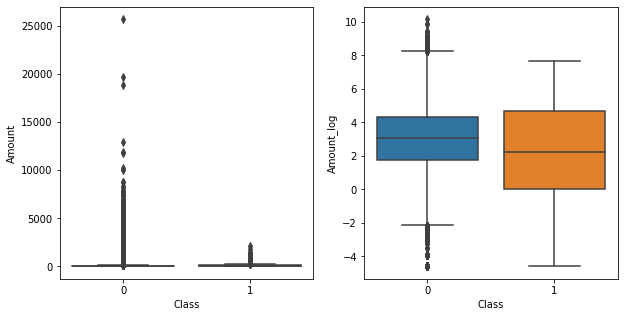

In [21]:
plot_box(df)

In [22]:
df = df.drop("Amount_log", axis =1)

## Belford's law

Fraudulent transactions don't follow belford's law as well as non-fraudulent transactions

In [23]:
#these are the Benford Law weights)
weights = np.asarray([0.301, 0.176, 0.124, 0.096, 0.079, 0.066, 0.057, 0.054, 0.047])

In [24]:
def get_belford_list(df):
    l = []
    for i in df["Amount"]:
        l.append(int(str(i)[0]))
    l = sorted([i for i in l if i != 0])
    return(l)

Text(0.5, 1.0, 'FRAUD')

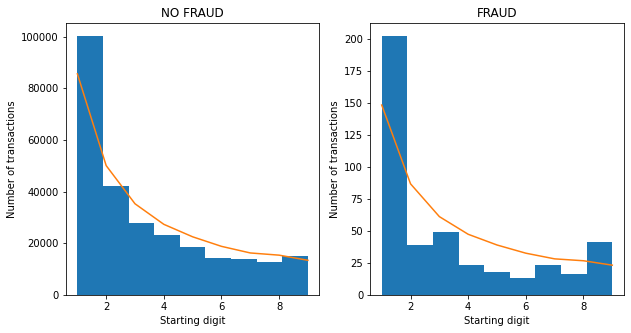

In [25]:
_, ax = plt.subplots(1, 2, figsize=  (10, 5))
ax[0].hist(get_belford_list(nofraud), bins = 9)
ax[0].plot(range(1, 10), weights*len(nofraud))
ax[0].set_xlabel("Starting digit")
ax[0].set_ylabel("Number of transactions")
ax[0].set_title("NO FRAUD")

ax[1].hist(get_belford_list(fraud), bins = 9)
ax[1].plot(range(1, 10), weights*len(fraud))
ax[1].set_xlabel("Starting digit")
ax[1].set_ylabel("Number of transactions")
ax[1].set_title("FRAUD")


## Correlation Analysis

In [26]:
corrs = df.corr()["Class"].drop(["Class"]).sort_values()

Text(0, 0.5, "Pearson's linear correlation with fraud")

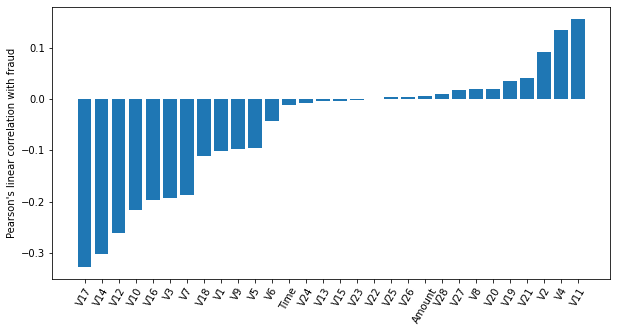

In [27]:
plt.figure(figsize = (10, 5))
plt.bar(corrs.index, corrs.values)
plt.xticks(rotation=60)
plt.ylabel("Pearson's linear correlation with fraud")

# Machine Learning Models

As we've seen so far, the dataset is very unbalanced, with less than 500 fraudulent transactions and over 200,000 total transactions. This has made it more dificult to do the data analysis and will also make it more dificult for machine learning models to learn.

I'm going to solve this using three approaches, training a linear model and an ensemble method on each one. To test each method I first split the data into training and testing then I apply the approaches:

- Weighted Classification: Weighted Classification consits of applying larger importance in training on the class that has less samples.
- Undersampling: Undersampling simply means removing some of the non-fraudulent data in this case. This approach will waste the majority of the collected data.
- Augmentation: We can try to generate data that is similar to the fraudulent one to try to create a more balanced dataset

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [30]:
df = df.drop("Time", axis = 1)

In [80]:
y = df["Class"].values
X = df.drop("Class", axis = 1)

#NORMALISE
X = (X-X.min())/(X.max()-X.min()) # min max

# X = (X - X.mean())/X.std().values #standard normalisation

In [81]:
X.describe().round(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,0.96,0.77,0.84,0.25,0.77,0.26,0.27,0.79,0.46,0.51,...,0.58,0.56,0.51,0.67,0.38,0.58,0.43,0.42,0.31,0.00
std,0.03,0.02,0.03,0.06,0.01,0.01,0.01,0.01,0.04,0.02,...,0.01,0.01,0.03,0.01,0.08,0.03,0.08,0.01,0.01,0.01
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.94,0.76,0.82,0.21,0.76,0.26,0.26,0.78,0.44,0.50,...,0.58,0.56,0.48,0.66,0.33,0.56,0.37,0.42,0.31,0.00
50%,0.96,0.77,0.84,0.25,0.77,0.26,0.27,0.79,0.46,0.51,...,0.58,0.56,0.51,0.67,0.39,0.58,0.42,0.42,0.31,0.00
75%,0.98,0.78,0.86,0.28,0.77,0.27,0.27,0.79,0.48,0.52,...,0.58,0.56,0.53,0.67,0.44,0.60,0.46,0.42,0.31,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [82]:
X_columns = X.columns

In [83]:
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [34]:
np.bincount(y_test)

array([93838,   149], dtype=int64)

# WEIGHTED CLASSIFICATION

By applying weights to each class we are able to force our model to focus more on the class with less samples

## Weighted Logistic Regression

In [35]:
clf = LogisticRegression(penalty="l2", class_weight="balanced", max_iter = 10000)

In [36]:
len(X) / (2 * np.bincount(y))

array([  0.50086524, 289.43800813])

In [37]:
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [38]:
c = (pd.DataFrame(classification_report(clf.predict(X_test), y_test, output_dict = True))*100).round(2)
c

,0,1,accuracy,macro avg,weighted avg
precision,97.83,90.60,97.82,94.22,97.66
recall,99.98,6.22,97.82,53.10,97.82
f1-score,98.90,11.63,97.82,55.26,96.88
support,9181500.00,217200.00,97.82,9398700.00,9398700.00


## Weighed Random Forest

In [39]:
RF_clf = RandomForestClassifier(class_weight='balanced')

In [40]:
RF_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [41]:
c = (pd.DataFrame(classification_report(RF_clf.predict(X_test), y_test, output_dict = True))*100).round(2)
c

,0,1,accuracy,macro avg,weighted avg
precision,100.00,77.18,99.96,88.59,99.97
recall,99.96,96.64,99.96,98.30,99.96
f1-score,99.98,85.82,99.96,92.90,99.96
support,9386800.00,11900.00,99.96,9398700.00,9398700.00


# UNDERSAMPLING

Undersampling is a way to make the datasets balanced by just avoiding to use most of the non-fraudulent data. The problem with this is that we stop using most of our data and only end up using a very small fraction

## Undersampling Logistic Regression

In [42]:
np.bincount(y_train)

array([190477,    343], dtype=int64)

In [43]:
indices = [np.random.choice(np.bincount(y_train)[0], np.bincount(y_train)[1])][0]

In [44]:
len(indices)

343

In [45]:
X_train_balanced = np.concatenate([X_train[y_train == 0][indices], X_train[y_train == 1]], axis = 0)
y_train_balanced = np.concatenate([y_train[y_train == 0][indices], y_train[y_train == 1]], axis = 0)

In [46]:
X_train_balanced.shape, y_train_balanced.shape

((686, 29), (686,))

In [47]:
np.bincount(y_train_balanced)

array([343, 343], dtype=int64)

In [48]:
clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [49]:
c = (pd.DataFrame(classification_report(clf.predict(X_test), y_test, output_dict = True))*100).round(2)
c

,0,1,accuracy,macro avg,weighted avg
precision,99.81,85.91,99.79,92.86,99.77
recall,99.98,42.38,99.79,71.18,99.79
f1-score,99.90,56.76,99.79,78.33,99.76
support,9368500.00,30200.00,99.79,9398700.00,9398700.00


## Undersampling Random Forest

In [50]:
RF_clf = RandomForestClassifier(class_weight='balanced')
RF_clf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(class_weight='balanced')

In [51]:
c = (pd.DataFrame(classification_report(RF_clf.predict(X_test), y_test, output_dict = True))*100).round(2)
c

,0,1,accuracy,macro avg,weighted avg
precision,97.63,92.62,97.62,95.12,97.51
recall,99.99,5.85,97.62,52.92,97.62
f1-score,98.80,11.00,97.62,54.90,96.59
support,9162700.00,236000.00,97.62,9398700.00,9398700.00


## Data Augmentation

In [73]:
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.DataDescriber import DataDescriber

In [116]:
fraud_norm = pd.DataFrame(X_train[y_train == 1], columns = X_columns)
nofraud_norm = pd.DataFrame(X_train[y_train == 0], columns = X_columns)

In [86]:
train_file = "creditcardfraud/fraud_train.csv"
pd.DataFrame(X_train[y_train == 1], columns = X_columns).to_csv(train_file)


In [110]:
# describer = DataDescriber()
# describer.describe_dataset_in_correlated_attribute_mode(dataset_file= train_file, 
#                                                         epsilon=0, 
#                                                         k=4)


In [ ]:
# describer.save_dataset_description_to_file("description.json")

In [156]:
X_train[y_train == 0].shape

(190477, 29)

In [157]:
n_fraudulent = len(X_train[y_train == 0]) - len(X_train[y_train == 1])

In [159]:
# generator = DataGenerator()
# generator.generate_dataset_in_correlated_attribute_mode(n_fraudulent, "description.json")
# generator.save_synthetic_data("sythetic_data2.csv")

In [160]:
synth = pd.read_csv("sythetic_data.csv", index_col =False).iloc[:, 1:]

In [161]:
synth.shape

(190134, 29)

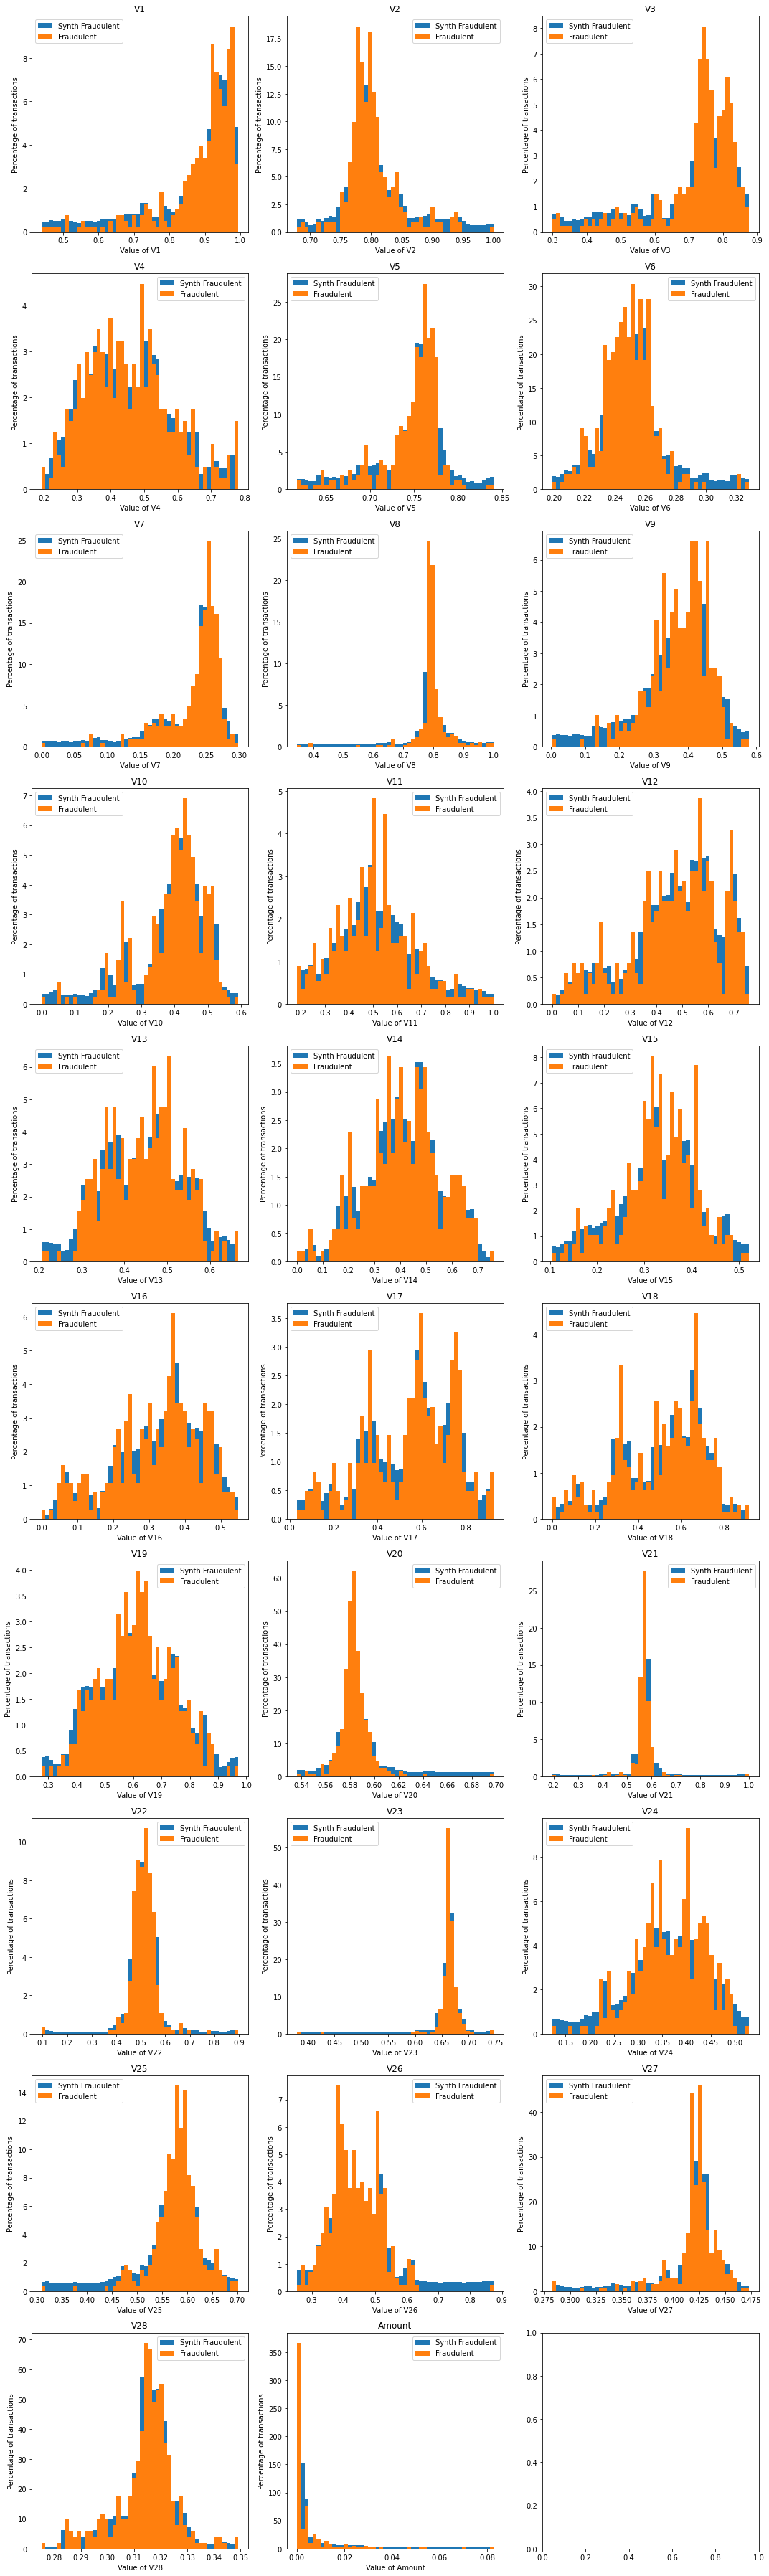

In [162]:
plot_data(fraud_norm, synth = synth, features = list(X_columns))

## Augmented Random Forest

In [164]:
X_train.shape, synth.shape

((190820, 29), (190134, 29))

In [194]:
X_train_augmented = np.concatenate([X_train, synth], axis = 0)
y_train_augmented = np.concatenate([y_train, [1]*len(synth)])

In [195]:
np.bincount(y_train_augmented)

array([190477, 190477], dtype=int64)

In [197]:
RF_clf = RandomForestClassifier()
RF_clf.fit(X_train_augmented, y_train_augmented)

RandomForestClassifier()

In [198]:
c = (pd.DataFrame(classification_report(RF_clf.predict(X_test), y_test, output_dict = True))*100).round(2)
c

,0,1,accuracy,macro avg,weighted avg
precision,99.88,87.25,99.86,93.56,99.85
recall,99.98,53.72,99.86,76.85,99.86
f1-score,99.93,66.50,99.86,83.21,99.84
support,9374500.00,24200.00,99.86,9398700.00,9398700.00


In [199]:
c = (pd.DataFrame(classification_report(RF_clf.predict(X_train), y_train, output_dict = True))*100).round(2)
c

,0,1,accuracy,macro avg,weighted avg
precision,100.0,100.0,100.0,100.0,100.0
recall,100.0,100.0,100.0,100.0,100.0
f1-score,100.0,100.0,100.0,100.0,100.0
support,19047700.0,34300.0,100.0,19082000.0,19082000.0


In [200]:
# Its overfitting 

In [201]:
synth_red = synth.sample(10000)

In [202]:
X_train_augmented = np.concatenate([X_train, synth_red], axis = 0)
y_train_augmented = np.concatenate([y_train, [1]*len(synth_red)])

In [ ]:
RF_clf = RandomForestClassifier(class_weight='balanced')
RF_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
c = (pd.DataFrame(classification_report(RF_clf.predict(X_test), y_test, output_dict = True))*100).round(2)
c

In [ ]:
c = (pd.DataFrame(classification_report(RF_clf.predict(X_train), y_train, output_dict = True))*100).round(2)
c

## Logistic Regression with Data Augmentation

In [183]:
X_train_augmented = np.concatenate([X_train, synth], axis = 0)
y_train_augmented = np.concatenate([y_train, [1]*len(synth)])

In [185]:
clf = LogisticRegression(penalty="l2", class_weight="balanced", max_iter = 10000)
clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [186]:
c = (pd.DataFrame(classification_report(clf.predict(X_test), y_test, output_dict = True))*100).round(2)
c

,0,1,accuracy,macro avg,weighted avg
precision,99.81,85.91,99.79,92.86,99.77
recall,99.98,42.38,99.79,71.18,99.79
f1-score,99.90,56.76,99.79,78.33,99.76
support,9368500.00,30200.00,99.79,9398700.00,9398700.00


TO DO:

- WHICH TRANSACTIONS ARE BEING MISSED BY THE MODEL? THE BIG ONES ?
- TRY NEURAL NETWORK ON AUGMENTED DATA